In [5]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import urllib2
import scipy.stats as stats

np.set_printoptions(precision=3, suppress=True)
url = ('https://raw.githubusercontent.com/Upward-Spiral-Science'
       '/data/master/syn-density/output.csv')
data = urllib2.urlopen(url)
csv = np.genfromtxt(data, delimiter=",")[1:] # don't want first row (labels)

# chopping data based on thresholds on x and y coordinates
x_bounds = (409, 3529)
y_bounds = (1564, 3124)

def check_in_bounds(row, x_bounds, y_bounds):
    if row[0] < x_bounds[0] or row[0] > x_bounds[1]:
        return False
    if row[1] < y_bounds[0] or row[1] > y_bounds[1]:
        return False
    if row[3] == 0:
        return False
    
    return True

indices_in_bound, = np.where(np.apply_along_axis(check_in_bounds, 1, csv, x_bounds, y_bounds))
data_thresholded = csv[indices_in_bound]
n = data_thresholded.shape[0]


def synapses_over_unmasked(row):
    s = (row[4]/row[3])*(64**3)
    return [row[0], row[1], row[2], s]

syn_unmasked = np.apply_along_axis(synapses_over_unmasked, 1, data_thresholded)
syn_normalized = syn_unmasked

### 1) Bic keeps getting better as we go up right now--let's look at more clusters!

#### 1.1 Looking at BIC curve for more clusters

(29L,)
[ 582952.469  581496.369  579983.42   578390.906  578513.909  577693.482
  577552.555  576618.172  576701.481  575915.735  575568.366  575115.115
  574440.496  574340.499  574282.911  574305.032  573913.693  573815.159
  574099.826  573762.589  573543.528  573644.251  573577.225  573557.455
  573074.396  573596.203  573260.791  560437.474  560399.363]
(29L,)


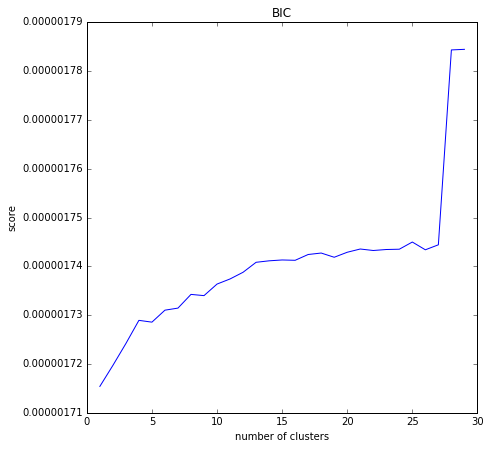

In [20]:
import sklearn.mixture as mixture

# Randomly Sample
samples = 10000
perm = np.random.permutation(xrange(1, len(syn_normalized[:])))
syn_normalized_sample = syn_normalized[perm[:samples]]
bics = []
max_clusters = 30
for i in range(1,15):
    bic = np.array([])
    i = np.array(range(1, max_clusters))
    for idx in range(1, max_clusters):
        gmm = mixture.GMM(n_components=idx, n_iter=1000, covariance_type='diag')
        gmm.fit(syn_normalized_sample)
        bic = np.append(bic, gmm.bic(syn_normalized_sample))
    bics.append(bic)
bic = np.asarray(bics)
bic_mean = np.max(bic,0)

plt.figure(figsize=(7,7))
plt.plot(i, 1.0/bic_mean)
plt.title('BIC')
plt.ylabel('score')
plt.xlabel('number of clusters')
plt.show()


#### 1.2) Compute mean, variance on each cluster

In [22]:
# From the BIC curve above, we see an elbow at 27 clusters. (Not sure what to do about the weird spike)

n_clusters = 27
gmm = mixture.GMM(n_components=n_clusters, n_iter=1000, covariance_type='diag')
clusters = [[] for i in xrange(n_clusters)]
predicted = gmm.fit_predict(syn_normalized_sample)
for label, row in zip(predicted, syn_normalized[:,]):
    clusters[label].append(row)

for i in xrange(n_clusters):
    clusters[i] = np.array(clusters[i])
    print "# of samples in cluster %d: %d" % (i+1, len(clusters[i])) 
    print "centroid: ", np.average(clusters[i], axis=0)
    print "cluster covariance: "
    covar = np.cov(clusters[i].T)
    print covar
    print "determinant of covariance matrix: ", np.linalg.det(covar)
    print

# of samples in cluster 1: 539
centroid:  [  804.137  2330.686   593.113   300.919]
cluster covariance: 
[[  61444.011   -4290.923    4150.38      140.2  ]
 [  -4290.923  224828.643    3371.53   -20304.189]
 [   4150.38     3371.53   126038.907   -1555.449]
 [    140.2    -20304.189   -1555.449   12825.653]]
determinant of covariance matrix:  1.90388745315e+19

# of samples in cluster 2: 231
centroid:  [  813.857  2309.052   635.948   308.497]
cluster covariance: 
[[  70233.671   -4325.875    -556.586   -4593.031]
 [  -4325.875  219734.945    7009.02   -20188.211]
 [   -556.586    7009.02   131854.876    -178.544]
 [  -4593.031  -20188.211    -178.544    9450.843]]
determinant of covariance matrix:  1.46886373427e+19

# of samples in cluster 3: 681
centroid:  [  837.313  2283.181   595.982   307.953]
cluster covariance: 
[[  63711.533   -2573.876    3383.525    -415.553]
 [  -2573.876  208882.154   11802.162  -18720.722]
 [   3383.525   11802.162  119425.632   -3071.567]
 [   -415.553 

#### 1.3) Scatter plot with 24 clusters

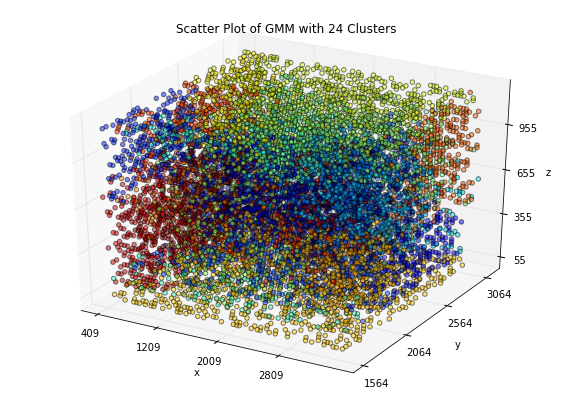

In [23]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.gca(projection='3d')
ax.view_init()
ax.dist = 10  # distance
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Scatter Plot of GMM with 24 Clusters')
ax.set_xticks(np.arange(min(syn_normalized_sample[:,0]), max(syn_normalized_sample[:,0])+1, 800))
ax.set_yticks(np.arange(min(syn_normalized_sample[:,1]), max(syn_normalized_sample[:,1])+1, 500))
ax.set_zticks(np.arange(min(syn_normalized_sample[:,2]), max(syn_normalized_sample[:,2])+1, 300))

ax.scatter(
           syn_normalized_sample[:, 0], syn_normalized_sample[:, 1], syn_normalized_sample[:, 2],  # data
           c=predicted,  # marker colour
           alpha=.5
    )

plt.show()

### 2) Looking at the "spike" from last time--PCA Analysis

Points in spike:  11465
Average Density:  0.00134070207006
Std Deviation:  8.46720771375e-05


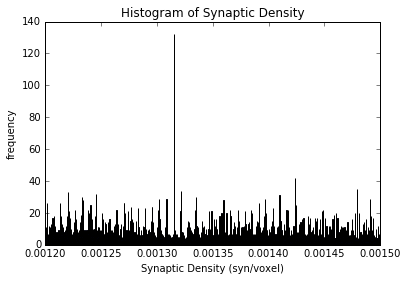

In [24]:
# Extract the spike
from mpl_toolkits.mplot3d import axes3d

a = np.apply_along_axis(lambda x:x[4]/x[3], 1, data_thresholded)

# Spike
spike = a[np.logical_and(a <= 0.0015, a >= 0.0012)]
print "Points in spike: ", len(spike)
print "Average Density: ", np.mean(spike)
print "Std Deviation: ", np.std(spike)

# Histogram
hist_n, bins, _ = plt.hist(spike, 2000)
plt.title('Histogram of Synaptic Density')
plt.xlabel('Synaptic Density (syn/voxel)')
plt.ylabel('frequency')

# Scatter plot
data_thresholded[:,4] = a
spike_coords = data_thresholded[np.logical_and(data_thresholded[:,4] <= 0.0015, data_thresholded[:,4] >= 0.0012)]

[[ 0.049 -0.476  0.467  0.743  0.   ]
 [-0.346 -0.693 -0.633 -0.023  0.   ]
 [ 0.921 -0.136 -0.357  0.077  0.   ]
 [-0.173  0.525 -0.504  0.664 -0.   ]]
[ 0.311  0.265  0.25   0.173]
(11465L, 4L)


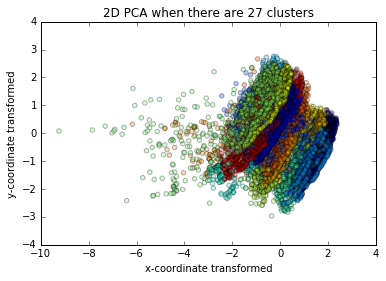

In [30]:
from sklearn.decomposition import PCA
import sklearn.mixture as mixture

# center each variable and give it unit variance for PCA

def center(row, means, std_devs):
    for idx, mean, std_dev in zip(range(4), means, std_devs):
        row[idx] -= mean
        row[idx] *= 1.0/std_dev
    return row

syn_centered = np.apply_along_axis(center, 1, spike_coords,
                                   *zip(*[(np.average(spike_coords[:, i]), 
                                   np.std(spike_coords[:, i])) for i in range(4)]))
pca = PCA(n_components = 4)
transform = pca.fit_transform(syn_centered)
print pca.components_
print pca.explained_variance_ratio_
print transform.shape

# plot the clusters along the first 2 principal components
n_clusters = 27
gmm = mixture.GMM(n_components=n_clusters, n_iter=1000, covariance_type='diag')
predicted = gmm.fit_predict(spike_coords)

plt.scatter(transform[:, 0], transform[:, 1], c=predicted, alpha=.3)
plt.title('2D PCA when there are 27 clusters')
plt.xlabel('x-coordinate transformed')
plt.ylabel('y-coordinate transformed')
plt.show()

Layer boundaries seem to be fairly well defined. Layers in along y-direction across x-direction.

### 3) Regressions on the "spike"

### 4) Visualization of the "spike"

### 5) Histograms from bijan